## Train classificacion model 

To perform the model train we use: *train_class2.sh*, with the following code

chemprop_train \
    --data_path ../Data/pIC50_class2.csv \    
    --dataset_type classification \
    --save_dir test_checkpoints_class2 \
    --target_columns pIC50 \
    --features_generator rdkit_2d_normalized --no_features_scaling \
    --save_smiles_splits


- **pIC50_class2.csv** : Dataset with 1482 compounds and 653 have inhibitory activity against NRAS. 
- **--target_columns pIC50** : binary variable according to pIC50 (if pIC50 is greater than 7 it is classified with 1)
- **--features_generator rdkit_2d_normalized --no_features_scaling** : pre-normalized RDKit features
- **--save_smiles_splits** : By default, random split the data into 80% train, 10% validation, and 10% test. With these line we can save the three datasets used, to further study of the results obtained. The diferents dataset are stored in *'test_checkpoints_class/fold_0'* :

    - Train data : "train_full" (smiles + pIC50) / "train_smiles" (only smiles)
    - Validation data : "val_full" (smiles + pIC50) / "val_smiles" (only smiles)
    - Test data : "test_full" (smiles + pIC50) / "test_smiles" (only smiles)

The model is trained for 30 epochs.
The default metric for classification is AUC.

## Evaluate the model on test data.

Now that we have trained the model, the next step is to evaluate its performance on a test dataset (the split one).

With *train_pred_class.sh* :

chemprop_predict \
    --test_path test_checkpoints_class2/fold_0/test_smiles.csv \
    --preds_path test_preds_class2.csv \
    --checkpoint_dir test_checkpoints_class2 \
    --features_generator rdkit_2d_normalized --no_features_scaling

- **test_preds_class2.csv** : predictions for the compounds in our test dataset

Moreover, in the following script we will compare the predicted values of our model against the real pIC50 classification. 

In [1]:
import pandas as pd
#load real pIC50 classification
df_true = pd.read_csv('test_checkpoints_class2/fold_0/test_full.csv')
print(df_true.columns)

Index(['SMILES', 'pIC50'], dtype='object')


In [2]:
#load predicted values
df_preds = pd.read_csv('test_preds_class2.csv')
print(df_preds.columns)

#column renaming to better manage data

df_preds.rename(columns={'pIC50': 'preds'}, inplace=True)
print(df_preds.columns)

Index(['SMILES', 'pIC50'], dtype='object')
Index(['SMILES', 'preds'], dtype='object')


In [3]:
#combination of the two data sets
df = df_true.merge(df_preds, on='SMILES', how='inner')

print(df)

                                                SMILES  pIC50     preds
0    CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    1.0  0.593462
1    CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    1.0  0.466743
2    CC(C)[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](Cc1cc...    0.0  0.000621
3    Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@H](O)C...    0.0  0.000263
4    CCC[C@]1(CCc2ccccc2)CC(=O)C([C@@H](CC)c2cccc(N...    0.0  0.001440
..                                                 ...    ...       ...
136  Oc1c(O)c2ccccc2c(O)c1C(=C1C(=O)C(=O)c2ccccc2C1...    0.0  0.000809
137  CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    1.0  0.552083
138  CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    0.0  0.279296
139  CC(C)[C@H]1SCC[C@H]1OC(=O)N[C@@H](Cc1ccccc1)[C...    0.0  0.000240
140  OC(=O)C[C@H](NC(=O)c1csc(CNS(=O)(=O)c2ccc(O)c(...    0.0  0.000097

[141 rows x 3 columns]


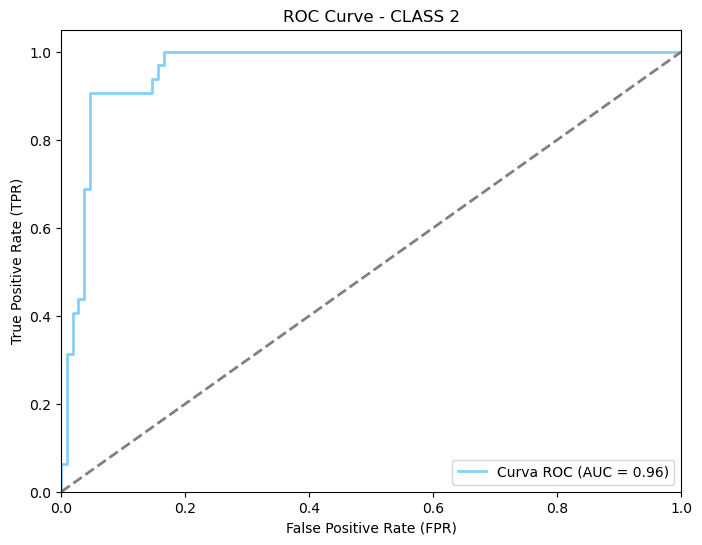

In [4]:
#ROC CURVE REPRESENTATION

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df.pIC50, df.preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='lightskyblue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - CLASS 2')
plt.legend(loc='lower right')

plt.savefig('../Results/Figures/curva_roc_class2.png', dpi=300) # saving the plot

plt.show()
